# Regression Trees (Supervised Learning)

This notebook demonstrates a CART-style **RegressionTreeRegressor** implemented from scratch. We follow a full ML workflow: data loading → train/test split → (optional) standardization → training → evaluation → hyperparameter exploration.

## 1. Set-up

We import the regression tree regressor from `rice_ml` and use scikit-learn only for **reference datasets** (not for models).

In [11]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# sklearn datasets (reference datasets only)
from sklearn.datasets import load_diabetes

def add_repo_src_to_path(max_up: int = 8) -> None:
    """Add <repo>/src to sys.path so we can import rice_ml without installing."""
    cur = os.path.abspath(os.getcwd())
    for _ in range(max_up):
        candidate = os.path.join(cur, "src")
        if os.path.isdir(os.path.join(candidate, "rice_ml")):
            if candidate not in sys.path:
                sys.path.insert(0, candidate)
            return
        cur = os.path.abspath(os.path.join(cur, ".."))
    raise RuntimeError("Could not find 'src/rice_ml'. Run this notebook inside the repo, or install the package.")

add_repo_src_to_path()

from rice_ml.processing.preprocessing import standardize, train_test_split
from rice_ml.supervised_learning.regression_trees import RegressionTreeRegressor

np.set_printoptions(precision=4, suppress=True)


## 2. Helpers

We define a few NumPy-only helper functions (metrics + a safe way to apply the training standardization parameters to the test set).

In [2]:
import inspect

def standardize_with_params(X: np.ndarray, params) -> np.ndarray:
    """Apply standardization using parameters returned by `standardize(X_train, return_params=True)`.

    Supports common parameter formats:
    - dict with keys: mean + scale (or std)
    - tuple/list: (mean, scale/std)
    """
    if isinstance(params, dict):
        mean = params.get("mean")
        scale = params.get("scale", params.get("std"))
    else:
        mean, scale = params
    return (X - mean) / scale

def rmse(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def r2_score_np(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    if ss_tot == 0:
        raise ValueError("R^2 is undefined when y_true is constant.")
    return float(1.0 - ss_res / ss_tot)

def evaluate_regression(model, X_train, y_train, X_test, y_test, title: str = "") -> None:
    """Print RMSE and R^2 for train/test."""
    p_tr = model.predict(X_train)
    p_te = model.predict(X_test)
    print(title)
    print("  train RMSE:", rmse(y_train, p_tr))
    print("  test  RMSE:", rmse(y_test, p_te))
    print("  train R^2 :", r2_score_np(y_train, p_tr))
    print("  test  R^2 :", r2_score_np(y_test, p_te))


## 3. Part A — Regression on the Diabetes Dataset

We start with a classic regression benchmark dataset. We keep a full preprocessing pipeline (split → fit standardization on train → apply to test). **Note:** trees generally do *not* require standardization, but we include it for consistency and to demonstrate a leak-free workflow.

In [3]:
data = load_diabetes()
X = data.data
y = data.target
feature_names = list(data.feature_names)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("First 8 feature names:", feature_names[:8])
print("Any NaN in X?", np.isnan(X).any())


X shape: (442, 10)
y shape: (442,)
First 8 feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4']
Any NaN in X? False


### 3.1 Train/test split and (optional) standardization

In [4]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=42
)

# Standardize using TRAIN statistics (optional for trees, but shown here)
X_train_std, params = standardize(X_train, return_params=True)

# Robustly apply params to test set (covers different `standardize` implementations)
sig = inspect.signature(standardize)
if "params" in sig.parameters:
    X_test_std = standardize(X_test, params=params)
else:
    X_test_std = standardize_with_params(X_test, params)

print("Train mean (approx):", X_train_std.mean(axis=0)[:5])
print("Train std  (approx):", X_train_std.std(axis=0)[:5])
print("Test  mean (approx):", X_test_std.mean(axis=0)[:5])
print("Test  std  (approx):", X_test_std.std(axis=0)[:5])


Train mean (approx): [ 0.  0.  0. -0. -0.]
Train std  (approx): [1. 1. 1. 1. 1.]
Test  mean (approx): [ 0.2195  0.109   0.0674  0.0849 -0.1043]
Test  std  (approx): [1.1416 1.0039 0.9997 0.8715 0.9182]


### 3.2 Fit a baseline regression tree

In [5]:
tree = RegressionTreeRegressor(max_depth=5, min_samples_leaf=5, random_state=42)
_ = tree.fit(X_train_std, y_train)

evaluate_regression(tree, X_train_std, y_train, X_test_std, y_test,
                    title="RegressionTreeRegressor (Diabetes) | max_depth=5, min_samples_leaf=5")


RegressionTreeRegressor (Diabetes) | max_depth=5, min_samples_leaf=5
  train RMSE: 42.20951995803669
  test  RMSE: 72.70612462927822
  train R^2 : 0.705112588255242
  test  R^2 : 0.043197487016474745


### 3.3 Hyperparameter exploration

We explore how **tree depth** and **leaf size** trade off bias vs. variance. As depth increases, training error often decreases, but test error may eventually stop improving (or worsen).

Best depth by test RMSE: 3


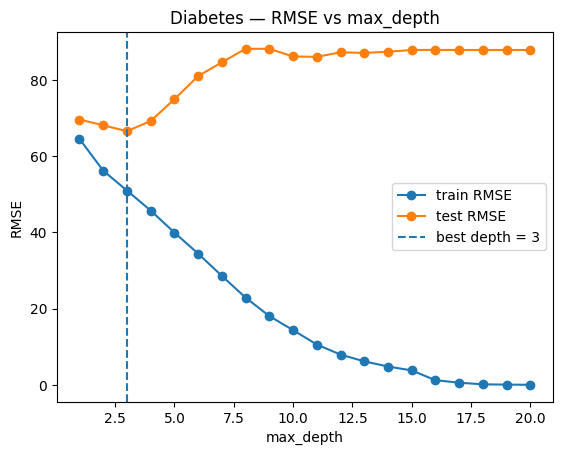

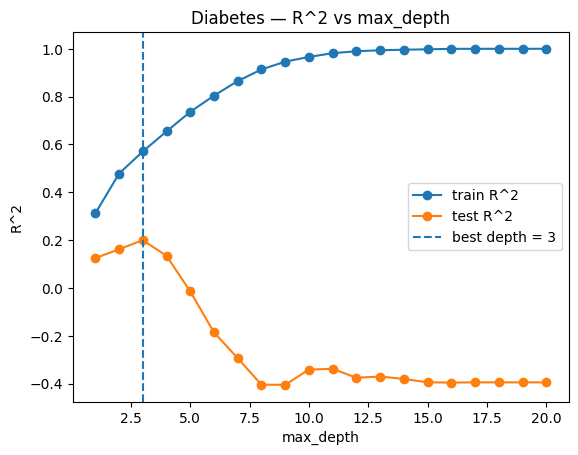

In [6]:
# Sweep max_depth
depths = list(range(1, 21))
train_rmse = []
test_rmse = []
train_r2 = []
test_r2 = []

for d in depths:
    m = RegressionTreeRegressor(max_depth=d, min_samples_leaf=1, random_state=42)
    m.fit(X_train_std, y_train)
    p_tr = m.predict(X_train_std)
    p_te = m.predict(X_test_std)
    train_rmse.append(rmse(y_train, p_tr))
    test_rmse.append(rmse(y_test, p_te))
    train_r2.append(r2_score_np(y_train, p_tr))
    test_r2.append(r2_score_np(y_test, p_te))

best_depth = depths[int(np.argmin(test_rmse))]
print("Best depth by test RMSE:", best_depth)

plt.figure()
plt.plot(depths, train_rmse, marker="o", label="train RMSE")
plt.plot(depths, test_rmse, marker="o", label="test RMSE")
plt.axvline(best_depth, linestyle="--", label=f"best depth = {best_depth}")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.title("Diabetes — RMSE vs max_depth")
plt.legend()
plt.show()

plt.figure()
plt.plot(depths, train_r2, marker="o", label="train R^2")
plt.plot(depths, test_r2, marker="o", label="test R^2")
plt.axvline(best_depth, linestyle="--", label=f"best depth = {best_depth}")
plt.xlabel("max_depth")
plt.ylabel("R^2")
plt.title("Diabetes — R^2 vs max_depth")
plt.legend()
plt.show()


Best min_samples_leaf (with best_depth): 20


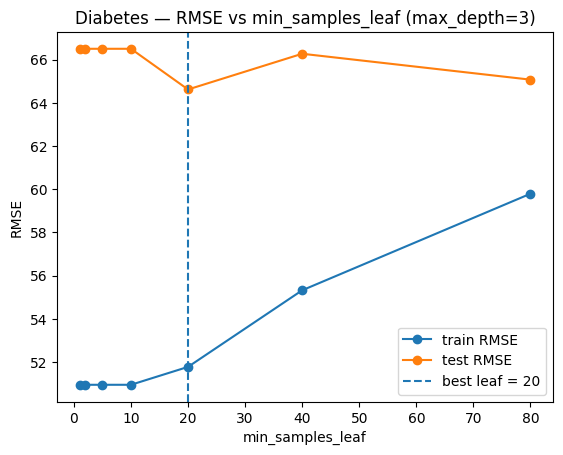

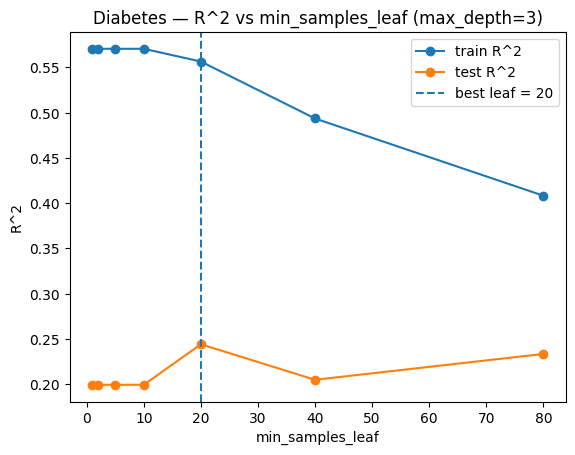

In [7]:
# Sweep min_samples_leaf while holding depth fixed at best_depth
leaf_sizes = [1, 2, 5, 10, 20, 40, 80]
train_rmse_l = []
test_rmse_l = []
train_r2_l = []
test_r2_l = []

for leaf in leaf_sizes:
    m = RegressionTreeRegressor(max_depth=best_depth, min_samples_leaf=leaf, random_state=42)
    m.fit(X_train_std, y_train)
    p_tr = m.predict(X_train_std)
    p_te = m.predict(X_test_std)
    train_rmse_l.append(rmse(y_train, p_tr))
    test_rmse_l.append(rmse(y_test, p_te))
    train_r2_l.append(r2_score_np(y_train, p_tr))
    test_r2_l.append(r2_score_np(y_test, p_te))

best_leaf = leaf_sizes[int(np.argmin(test_rmse_l))]
print("Best min_samples_leaf (with best_depth):", best_leaf)

plt.figure()
plt.plot(leaf_sizes, train_rmse_l, marker="o", label="train RMSE")
plt.plot(leaf_sizes, test_rmse_l, marker="o", label="test RMSE")
plt.axvline(best_leaf, linestyle="--", label=f"best leaf = {best_leaf}")
plt.xlabel("min_samples_leaf")
plt.ylabel("RMSE")
plt.title(f"Diabetes — RMSE vs min_samples_leaf (max_depth={best_depth})")
plt.legend()
plt.show()

plt.figure()
plt.plot(leaf_sizes, train_r2_l, marker="o", label="train R^2")
plt.plot(leaf_sizes, test_r2_l, marker="o", label="test R^2")
plt.axvline(best_leaf, linestyle="--", label=f"best leaf = {best_leaf}")
plt.xlabel("min_samples_leaf")
plt.ylabel("R^2")
plt.title(f"Diabetes — R^2 vs min_samples_leaf (max_depth={best_depth})")
plt.legend()
plt.show()


### 3.4 Feature subsampling (`max_features`)

Feature subsampling is mainly useful inside **ensembles** (e.g., Random Forests). For a *single* tree it can help or hurt depending on the dataset. We compare a few common settings.

In [12]:
p = X_train_std.shape[1]
settings = [
    ("all (None)", None),
    ("sqrt(p)", int(np.sqrt(p))),
    ("0.3*p", 0.3),
]

rows = []
for name, mf in settings:
    m = RegressionTreeRegressor(max_depth=best_depth, min_samples_leaf=best_leaf,
                               max_features=mf, random_state=42)
    m.fit(X_train_std, y_train)
    p_tr = m.predict(X_train_std)
    p_te = m.predict(X_test_std)

    rows.append({
        "setting": name,
        "max_features": mf,
        "train_RMSE": rmse(y_train, p_tr),
        "test_RMSE": rmse(y_test, p_te),
        "train_R2": r2_score_np(y_train, p_tr),
        "test_R2": r2_score_np(y_test, p_te),
    })

df = pd.DataFrame(rows)
df


,setting,max_features,train_RMSE,test_RMSE,train_R2,test_R2
0,all (None),NaN,51.767501,64.618479,0.556443,0.244223
1,sqrt(p),3.0,60.847536,66.552117,0.387196,0.198314
2,0.3*p,0.3,60.847536,66.552117,0.387196,0.198314


## 4. Part B — 1D Synthetic Regression (Visualization)

To visualize what regression trees learn, we use a 1D dataset with a nonlinear target. Regression trees produce **piecewise-constant** predictions; increasing depth gives finer partitions.

In [13]:
rng = np.random.default_rng(0)

n = 300
X1 = rng.uniform(-3.0, 3.0, size=(n, 1))
# nonlinear function + small noise
y1 = np.sin(X1[:, 0]) + 0.3 * (X1[:, 0] > 0).astype(float) + rng.normal(0.0, 0.15, size=n)

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.25, shuffle=True, random_state=42
)

# Standardization is optional, but keep the workflow consistent
X1_train_std, params1 = standardize(X1_train, return_params=True)
sig = inspect.signature(standardize)
if "params" in sig.parameters:
    X1_test_std = standardize(X1_test, params=params1)
else:
    X1_test_std = standardize_with_params(X1_test, params1)

print("X1_train shape:", X1_train_std.shape, "X1_test shape:", X1_test_std.shape)
print("Train mean (approx):", X1_train_std.mean(axis=0))
print("Train std  (approx):", X1_train_std.std(axis=0))


X1_train shape: (225, 1) X1_test shape: (75, 1)
Train mean (approx): [-0.]
Train std  (approx): [1.]


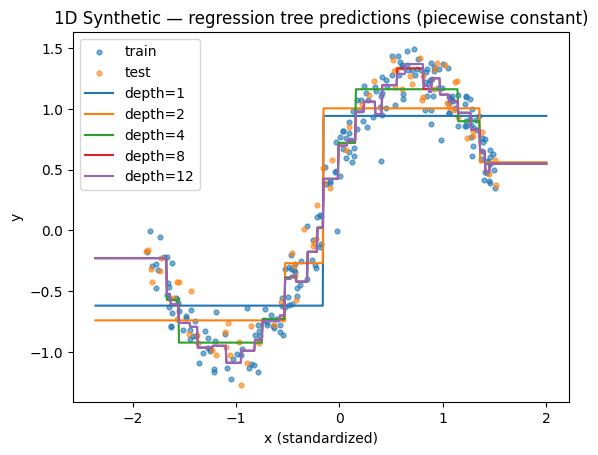

In [14]:
# Fit trees with different depths and plot predictions on a grid
grid = np.linspace(X1_train_std.min() - 0.5, X1_train_std.max() + 0.5, 600).reshape(-1, 1)

depth_list = [1, 2, 4, 8, 12]
plt.figure()
plt.scatter(X1_train_std[:, 0], y1_train, s=12, alpha=0.6, label="train")
plt.scatter(X1_test_std[:, 0], y1_test, s=12, alpha=0.6, label="test")

for d in depth_list:
    m = RegressionTreeRegressor(max_depth=d, min_samples_leaf=5, random_state=0).fit(X1_train_std, y1_train)
    pred_grid = m.predict(grid)
    plt.plot(grid[:, 0], pred_grid, label=f"depth={d}")

plt.xlabel("x (standardized)")
plt.ylabel("y")
plt.title("1D Synthetic — regression tree predictions (piecewise constant)")
plt.legend()
plt.show()


Best depth by test RMSE (synthetic): 6


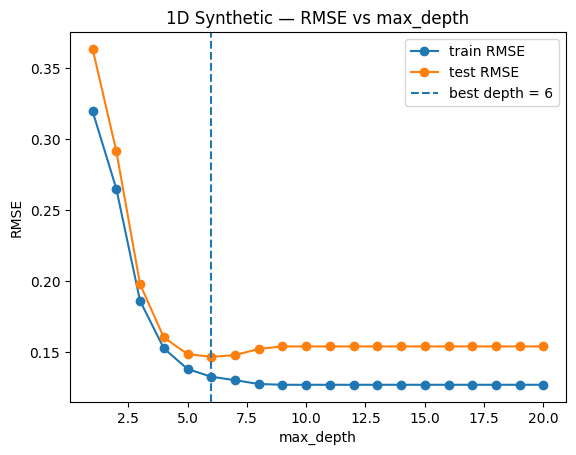

In [15]:
# Quantify RMSE vs depth on the synthetic problem
depths2 = list(range(1, 21))
tr = []
te = []
for d in depths2:
    m = RegressionTreeRegressor(max_depth=d, min_samples_leaf=5, random_state=0).fit(X1_train_std, y1_train)
    tr.append(rmse(y1_train, m.predict(X1_train_std)))
    te.append(rmse(y1_test, m.predict(X1_test_std)))

best_d2 = depths2[int(np.argmin(te))]
print("Best depth by test RMSE (synthetic):", best_d2)

plt.figure()
plt.plot(depths2, tr, marker="o", label="train RMSE")
plt.plot(depths2, te, marker="o", label="test RMSE")
plt.axvline(best_d2, linestyle="--", label=f"best depth = {best_d2}")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.title("1D Synthetic — RMSE vs max_depth")
plt.legend()
plt.show()


## Conclusion

In this notebook we implemented a CART-style **RegressionTreeRegressor**  and evaluated how tree complexity controls the **bias–variance tradeoff** in regression.

### 1) Diabetes dataset (real-world, 5 standardized features)

- **Scaling is not essential for trees, but the pipeline still matters.**  
  After standardization (fit on train, applied to test), the train distribution is centered with unit variance while the test distribution differs slightly—this is normal and confirms we avoided data leakage. As expected for trees, scaling does not fundamentally change how splits work (they depend on threshold comparisons, not distances/gradients).

- **Clear overfitting as depth increases.**  
  From the plots, **train RMSE decreases monotonically** and **train R² approaches 1** as `max_depth` grows, meaning deeper trees can memorize the training set.  
  However, **test RMSE is minimized at a shallow depth (best depth ≈ 3)** and then gets worse, while **test R² peaks around that same depth and becomes negative at larger depths**—a classic sign of high-variance overfitting.

- **Regularization via `min_samples_leaf` improves generalization.**  
  With `max_depth=3`, the sweep shows the best test performance occurs at a **larger leaf size (best `min_samples_leaf` ≈ 20)**. Increasing leaf size reduces overly specific splits and stabilizes the model on this noisy dataset.

- **A single tree has limited predictive power here.**  
  An example configuration like `max_depth=5, min_samples_leaf=5` achieved **train RMSE ≈ 42** vs **test RMSE ≈ 73** (train R² ≈ 0.71 vs test R² ≈ 0.04), showing a large generalization gap.  
  After tuning, the best setting reduced test error (test RMSE around the mid-60s with test R² around ~0.24), but performance still plateaus—consistent with the fact that a *single* tree is often not the strongest model for tabular regression.

- **`max_features` subsampling helped less for a single tree.**  
  Using **all features** produced the best test RMSE (~64.6), while restricting features (`sqrt(p)` or `0.3*p`) slightly worsened test RMSE. This is expected: feature subsampling is mainly beneficial when combined with **ensembles** (e.g., Random Forests), where diversity across trees is averaged.

### 2) 1D synthetic example (interpretability + intuition)

- The prediction curves clearly show regression trees produce **piecewise-constant** functions with axis-aligned thresholds.  
- As depth increases, the tree can approximate the underlying nonlinear trend better at first, but eventually starts fitting noise. In this run, the **best depth by test RMSE was around 6**, matching the “sweet spot” behavior seen in the real dataset.

### In conslusion:
- **Regression trees** approximate nonlinear functions using **axis-aligned splits** and produce **piecewise-constant** predictions.
- Increasing `max_depth` typically decreases training error, but test performance may plateau or degrade due to overfitting.
- `min_samples_leaf` acts as a regularizer: larger leaves reduce variance but can underfit.
- Feature subsampling via `max_features` is usually most beneficial in **ensembles** (e.g., Random Forests), and may or may not help a single tree.
- Although standardization is not required for trees, we kept a consistent preprocessing workflow (fit transforms on train only) to avoid data leakage and align with best practices.


